In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import ks_2samp
from itertools import product


from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer, KNNImputer
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

%matplotlib inline 
plt.style.use('dark_background')


In [59]:
clinical_df = pd.read_csv('Data/clinical_train.csv')
clinical_test_df = pd.read_csv('Data/clinical_test.csv')
molecular_df = pd.read_csv('Data/molecular_train.csv')
molecular_test_df = pd.read_csv('Data/molecular_test.csv')
target_df = pd.read_csv('Data/target_train.csv')

## Data Preparation

In [60]:
target_df.dropna(inplace=True)
target_df.reset_index(drop=True, inplace=True)
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool).map({True:1,False:0})

In [61]:
class CoxModelEvaluator:
    def __init__(self, X, y, n_splits=5, random_state=0):
        self.X = X
        self.y = y
        self.kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.cox_cindex_c_train_scores = []
        self.cox_cindex_c_test_scores = []

    def evaluate_model(self, imputer=KNNImputer(n_neighbors=4)):
        self.cox_cindex_c_train_scores = [] # Rest previous scores
        self.cox_cindex_c_test_scores = []
        for train_index, test_index in self.kf.split(self.X,self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            imputer = imputer
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)

            cox_c = CoxPHSurvivalAnalysis()
            cox_c.fit(X_train, y_train)

            cox_cindex_c_train = concordance_index_ipcw(y_train, y_train, cox_c.predict(X_train), tau=7)[0]
            cox_cindex_c_test = concordance_index_ipcw(y_train, y_test, cox_c.predict(X_test), tau=7)[0]

            self.cox_cindex_c_train_scores.append(cox_cindex_c_train)
            self.cox_cindex_c_test_scores.append(cox_cindex_c_test)

        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on train: {np.mean(self.cox_cindex_c_train_scores):.2f}")
        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on test: {np.mean(self.cox_cindex_c_test_scores):.2f}")

In [62]:
import re
def parse_cytogenetics(cytogenetics_str):
    modal_number_match = re.search(r'^\d+', cytogenetics_str)
    modal_number = modal_number_match.group() if modal_number_match else None  # Extract modal number
    sex_chromosomes_match = re.search(r'(xx|xy)', cytogenetics_str, re.IGNORECASE)
    sex_chromosomes = sex_chromosomes_match.group() if sex_chromosomes_match else None  # Extract sex chromosomes
    abnormalities = re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', cytogenetics_str)
    subclones = re.findall(r'/\d+', cytogenetics_str)
    return {
        "modal_number": modal_number,
        "sex_chromosomes": sex_chromosomes,
        "abnormalities": abnormalities,
        "subclones": subclones
    }

# Example input
cytogenetics_str = clinical_df['CYTOGENETICS'].iloc[12]
parsed = parse_cytogenetics(cytogenetics_str)
print(parsed)


clinical_df['CYTOGENETICS'] = clinical_df['CYTOGENETICS'].fillna('NA')
# Add gender column while being careful about the None type, give an average if unknown
clinical_df['GENDER'] = clinical_df['CYTOGENETICS'].apply(lambda x: 1 if re.search(r'xy', x, re.IGNORECASE) \
    else (0 if re.search(r'xx', x, re.IGNORECASE) else 0.5))

# Add number of abnormalities column
clinical_df['NUM_ABNORMALITIES'] = clinical_df['CYTOGENETICS'].apply(lambda x: len(re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', x)))

# Add number of chromosomes over or under 46 column
clinical_df['CHROMOSOME_DIFF'] = clinical_df['CYTOGENETICS'].apply(lambda x: abs(int(re.search(r'^\d+', x).group()) - 46) if re.search(r'^\d+', x) else 0)

{'modal_number': '45', 'sex_chromosomes': 'xy', 'abnormalities': ['-7'], 'subclones': ['/46']}


In [63]:
X = clinical_df.loc[clinical_df['ID'].isin(target_df['ID'])].copy()
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)


tmp = molecular_df.groupby('ID').size().reset_index(name='Nb mut')
X = X.merge(tmp, on='ID', how='left').fillna({'Nb mut': 0})

# X = X.drop(columns=['CYTOGENETICS','ID','GENDER','CENTER'])


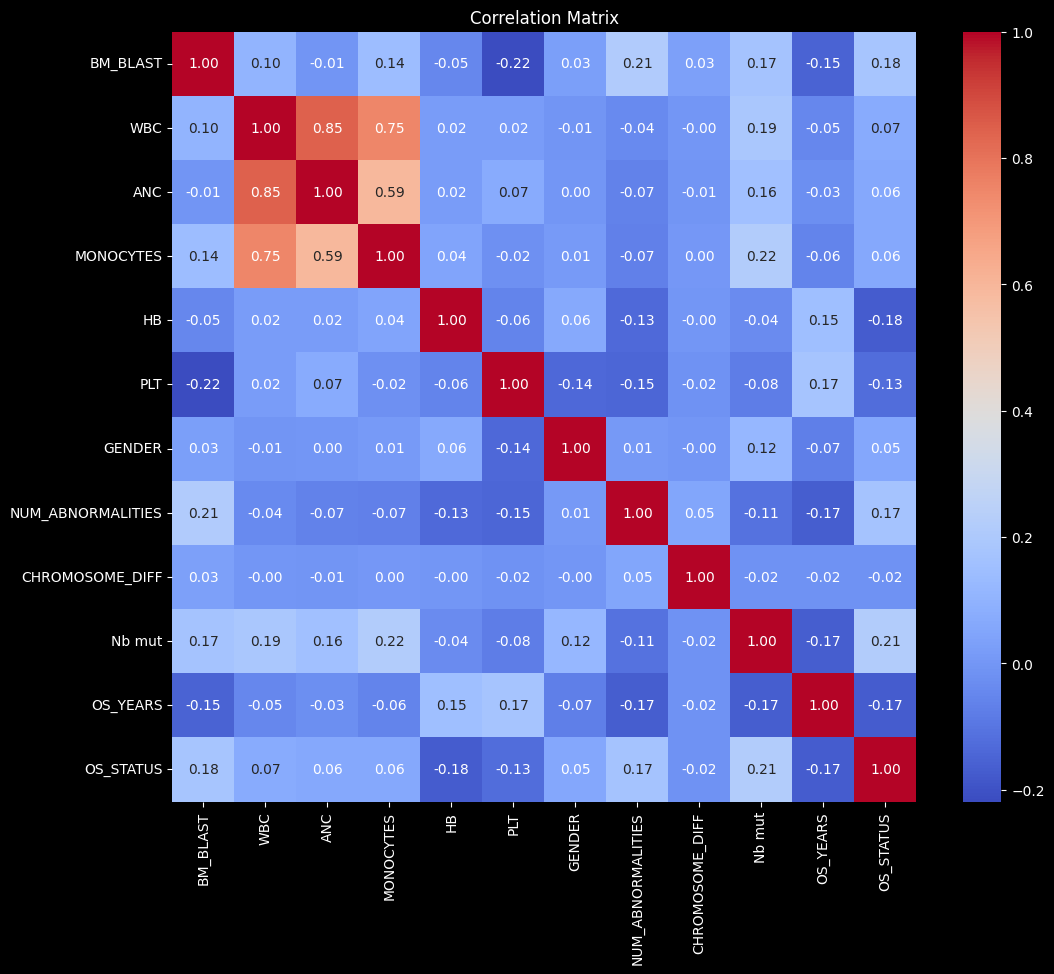

In [64]:
merged = X.merge(target_df, on='ID', how='left')
correlation_matrix = merged.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [65]:
drop_features = ['ID', 'CENTER', 'CYTOGENETICS']
X = X.drop(columns=drop_features)

In [66]:
evaluator = CoxModelEvaluator(X, y)
evaluator.evaluate_model()

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average Cox Proportional Hazard Model Concordance Index IPCW on train: 0.71
Average Cox Proportional Hazard Model Concordance Index IPCW on test: 0.70


#### Feature Importance

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [68]:
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [69]:
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
y_train_lgb = y_train['OS_STATUS']

train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
lgbm_model = lgb.train(lgbm_params, train_data, num_boost_round=1000)

train_ci_ipcw = concordance_index_ipcw(y_train, y_train, lgbm_model.predict(X_train_lgb), tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, lgbm_model.predict(X_test_lgb), tau=7)[0]
print(f"Train CI IPCW: {train_ci_ipcw:.4f}")
print(f"Test CI IPCW: {test_ci_ipcw:.4f}")

Train CI IPCW: 0.7992
Test CI IPCW: 0.6557


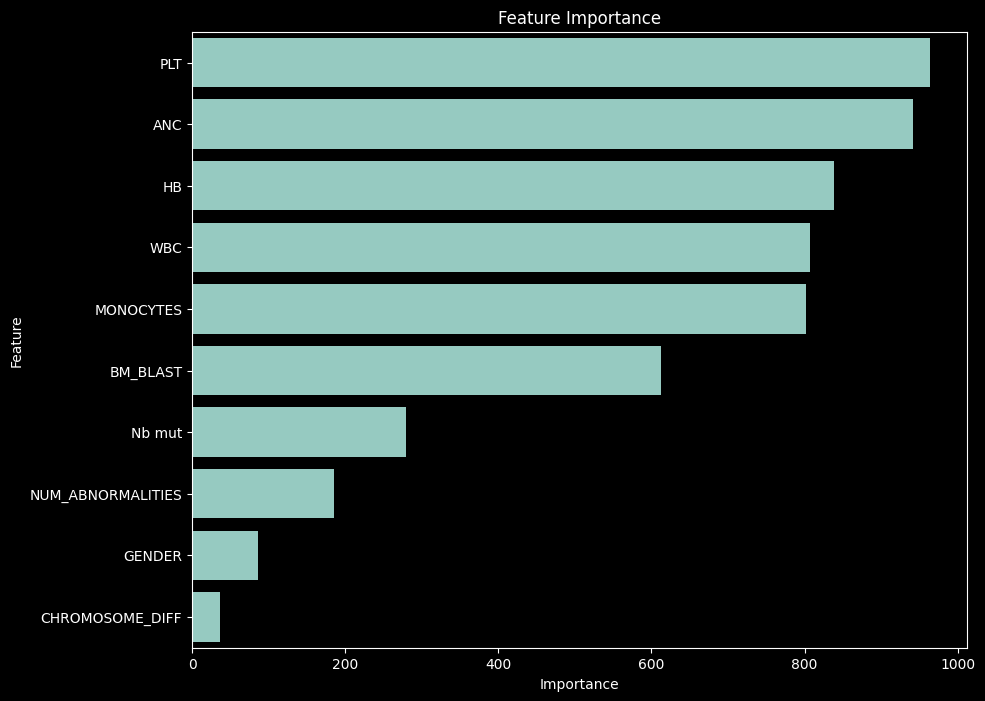

In [70]:
# Get feature importance
importance = lgbm_model.feature_importance()
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the feature importance dataframe
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [71]:
rf_params = {
    'max_depth': 3,
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': -1
}

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train['OS_YEARS'])

train_ci_ipcw_rf = concordance_index_ipcw(y_train, y_train, rf_model.predict(X_train), tau=7)[0]
test_ci_ipcw_rf = concordance_index_ipcw(y_train, y_test, rf_model.predict(X_test), tau=7)[0]
print(f"Train CI IPCW RF: {train_ci_ipcw_rf:.4f}")
print(f"Test CI IPCW RF: {test_ci_ipcw_rf:.4f}")

Train CI IPCW RF: 0.3012
Test CI IPCW RF: 0.3238


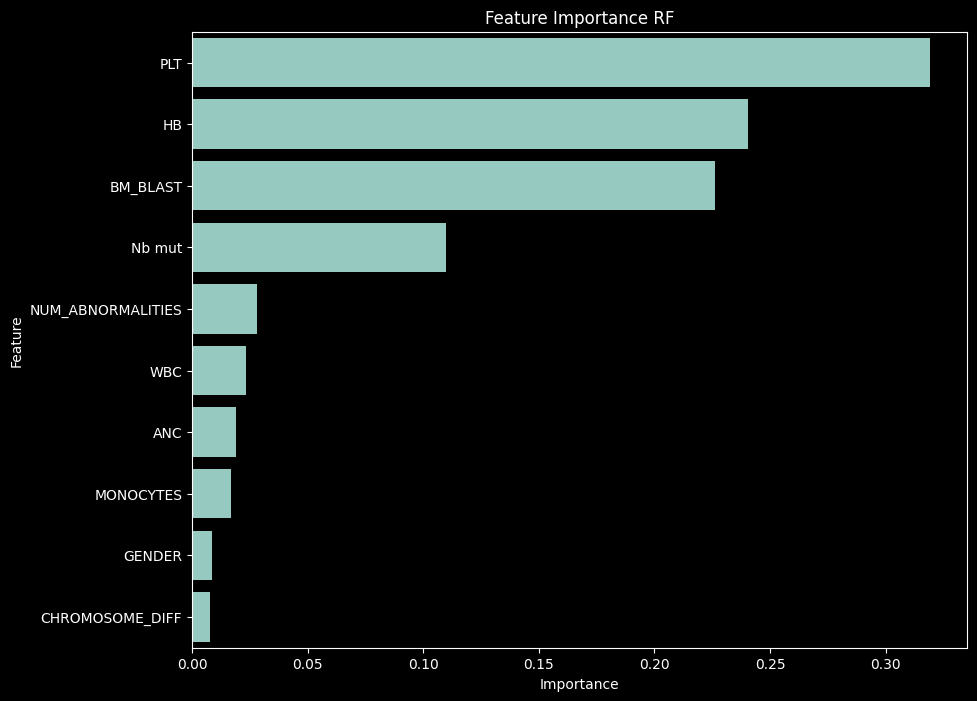

In [72]:
# Get feature importance
importance_rf = rf_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance_rf})
# Sort the feature importance dataframe
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf)
plt.title('Feature Importance RF')
plt.show()


## Training

In [73]:
class RandomSurvivalForestEvaluator:
    def __init__(self, X, y, n_estimators=200, min_samples_split=30, min_samples_leaf=15, max_features=0.5, random_state=42, n_jobs=-1, n_splits=5):
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.rsf = RandomSurvivalForest(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=random_state,
            n_jobs=n_jobs
        )
        self.rsf_cindex_train = []
        self.rsf_cindex_test = []

    def train(self):
        for train_index, test_index in self.kf.split(self.X, self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]
            imputer = SimpleImputer(strategy='mean')
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            self.rsf.fit(X_train, y_train)

            rsf_cindex_train_val = concordance_index_ipcw(y_train, y_train, self.rsf.predict(X_train), tau=7)[0]
            rsf_cindex_test_val = concordance_index_ipcw(y_train, y_test, self.rsf.predict(X_test), tau=7)[0]
            self.rsf_cindex_train.append(rsf_cindex_train_val)
            self.rsf_cindex_test.append(rsf_cindex_test_val)

    def get_scores(self):
        print(f"Average Random Survival Forest IPCW-Index train: {np.mean(self.rsf_cindex_train):.4f}")
        print(f"Average Random Survival Forest IPCW-Index test: {np.mean(self.rsf_cindex_test):.4f}")
    
    def score_reset(self):
        self.rsf_cindex_test = []
        self.rsf_cindex_train = []

In [75]:
eval_rsf = RandomSurvivalForestEvaluator(X, y)
eval_rsf.train()

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [76]:
eval_rsf.get_scores()

Average Random Survival Forest IPCW-Index train: 0.7773
Average Random Survival Forest IPCW-Index test: 0.7042
